In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, root_mean_squared_log_error
from skopt import BayesSearchCV 
from xgboost import XGBRegressor


import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize


In [2]:
data=pd.read_csv('E:/AI engineer/Guvi/Capstone Projects/Project3/train_tranformed_scaled.csv')

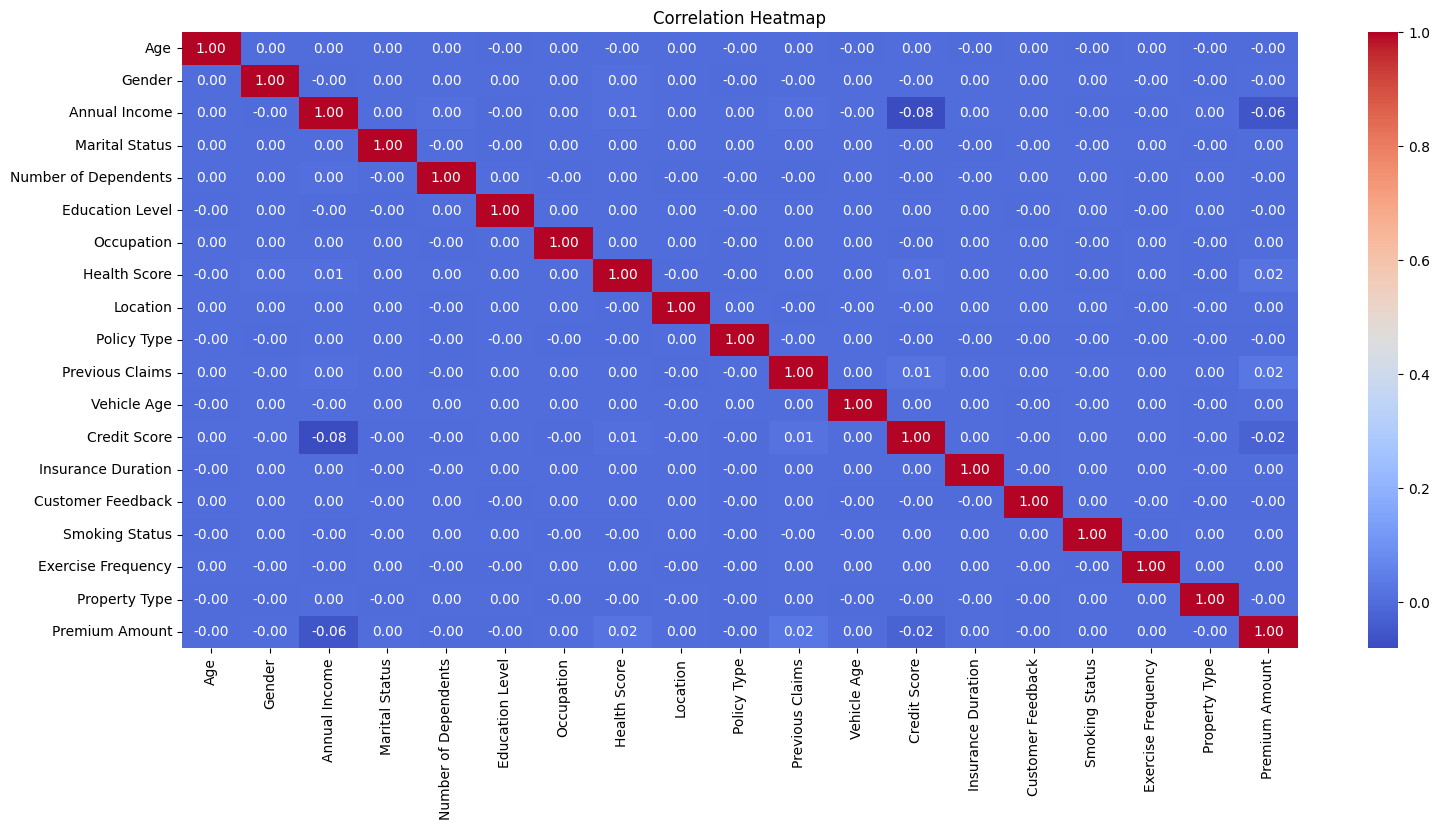

In [3]:
# Calculate correlation matrix
corr_matrix = data.corr()

# Plot correlation heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [4]:
# Correlation with target variable
print(corr_matrix['Premium Amount'].sort_values(ascending=False))

Premium Amount          1.000000
Previous Claims         0.024948
Health Score            0.019062
Marital Status          0.003666
Occupation              0.002110
Location                0.001462
Smoking Status          0.000544
Insurance Duration      0.000521
Exercise Frequency      0.000462
Vehicle Age             0.000273
Gender                 -0.000296
Property Type          -0.000366
Customer Feedback      -0.000814
Number of Dependents   -0.000842
Policy Type            -0.000904
Education Level        -0.001188
Age                    -0.002774
Credit Score           -0.022726
Annual Income          -0.058934
Name: Premium Amount, dtype: float64


In [14]:

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    """Train a model and evaluate its performance."""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmsle = root_mean_squared_log_error(y_test, y_pred)
    
    return rmse, mae, r2,rmsle

In [10]:
def compare_models(models, X_train, y_train, X_test, y_test):
    """Train and evaluate multiple models, and compare their performance."""
    results = []
    
    for model_name, model in models.items():
        # Train and evaluate the model
        rmse, mae, r2,rmsle = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
        
        # Store the results
        results.append({
            'Model': model_name,
            'RMSE': rmse,
            'MAE': mae,
            'R² Score': r2,
            'RMSLE': rmsle
        })
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

## Feature Selection

In [ ]:
# Train an XGBoost model for feature importance analysis
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

## Model Training

In [7]:
# Split data
X = data.drop(columns=['Premium Amount'])
y = data['Premium Amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Train models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "XGBoost": XGBRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

In [17]:
import lightgbm as lgb

# 5. Create LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# 6. Set LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# 7. Train the LightGBM model
# 7. Train the LightGBM model
model = lgb.train(params,
                  train_data,
                  num_boost_round=100,  # Adjust number of rounds
                  valid_sets=[test_data],
                  callbacks=[lgb.early_stopping(10)])

# 8. Make predictions on the test set
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# 9. Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmsle = root_mean_squared_log_error(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')
print(f'MAE Score: {mae}')
print(f'Rrmsle Score: {rmsle}')

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 13.164
RMSE: 13.164048434066054
R2 Score: 0.02574338992439018
MAE Score: 10.3042480085846
Rrmsle Score: 0.4714783355030684


In [15]:
# Compare the models
results_df = compare_models(models, X_train, y_train, X_test, y_test)
print(results_df)

               Model       RMSE        MAE  R² Score     RMSLE
0  Linear Regression  13.301789  10.479880  0.005249  0.477537
1      Decision Tree  19.251541  15.075141 -1.083653  0.681391
2            XGBoost  13.188052  10.321638  0.022187  0.471990
3      Random Forest  13.331812  10.439434  0.000753  0.474737


## Model tuning

In [ ]:
# Bayesian Optimization for Random Forest
rf_search = BayesSearchCV(
    RandomForestRegressor(random_state=42),
    {
        'n_estimators': (50, 300),  # Number of trees
        'max_depth': (3, 20),       # Depth of each tree
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 10)
    },
    n_iter=20,  # Number of iterations
    cv=3,       # Cross-validation
    scoring='neg_mean_absolute_error',
    random_state=42
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
evaluate_model(best_rf, X_test, y_test)

In [ ]:
from bayes_opt import BayesianOptimization
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Define the function to maximize
def objective(n_estimators, learning_rate, max_depth):
    model = XGBRegressor(
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        objective='reg:squarederror',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -mean_absolute_error(y_test, y_pred)  # We minimize MAE, so return negative MAE

# Define parameter search space
param_bounds = {
    "n_estimators": (50, 300),
    "learning_rate": (0.01, 0.3),
    "max_depth": (3, 20),
}

# Run Bayesian Optimization
optimizer = BayesianOptimization(
    f=objective,
    pbounds=param_bounds,
    random_state=42
)

optimizer.maximize(n_iter=20)  # Perform 20 iterations

# Best parameters
print(optimizer.max)


|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
